## Predicting Bank Customer Churn Using Machine Learning

### Load libraries

In [ ]:
pip install seaborn --upgrade

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.under_sampling import TomekLinks
import random
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### Load data

In [100]:
df = pd.read_csv('/Users/Brian/Dropbox/Data_Science/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [101]:
#define response variable
y = pd.Series(np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0), df.index)
#add y column to beginning of df for modeling purposes
df.insert(0,'y', pd.Series(np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0), df.index))

In [102]:
#drop first two columns which are not predictive
df = df.drop(['Attrition_Flag','CLIENTNUM'],axis=1)
df = df.iloc[:,0:-2]

### Exploratory Data Analysis

In [103]:
df.shape

(10127, 20)

In [104]:
df.describe()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.160660,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,0.367235,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,0.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,0.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,0.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,1.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   y                         10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [8]:
#correlation plot
df.corr()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
y,1.000000,0.018203,0.018991,0.013687,-0.150005,0.152449,0.204491,-0.023873,-0.263053,-0.000285,-0.131063,-0.168598,-0.371403,-0.290054,-0.178410
Customer_Age,0.018203,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114
Dependent_count,0.018991,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135
Months_on_book,0.013687,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,-0.150005,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.152449,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503
Contacts_Count_12_mon,0.204491,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471
Credit_Limit,-0.023873,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965
Total_Revolving_Bal,-0.263053,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022
Avg_Open_To_Buy,-0.000285,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808


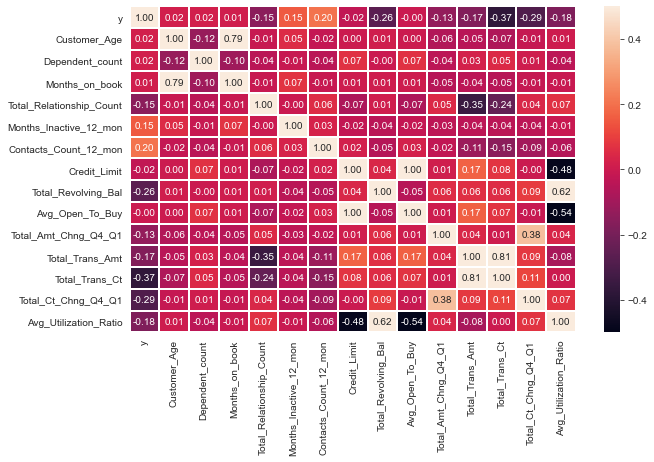

In [40]:
#correlation heatmap
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True,lw=1,robust=True,fmt='.2f',vmin=-0.5,vmax=0.5)

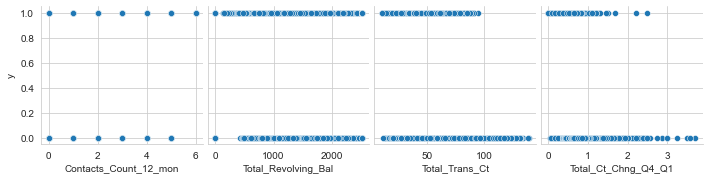

In [28]:
#pairplot not too useful with binary response
sns.pairplot(df, y_vars=['y'],x_vars=['Contacts_Count_12_mon',
                      'Total_Revolving_Bal','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1'],kind='scatter')

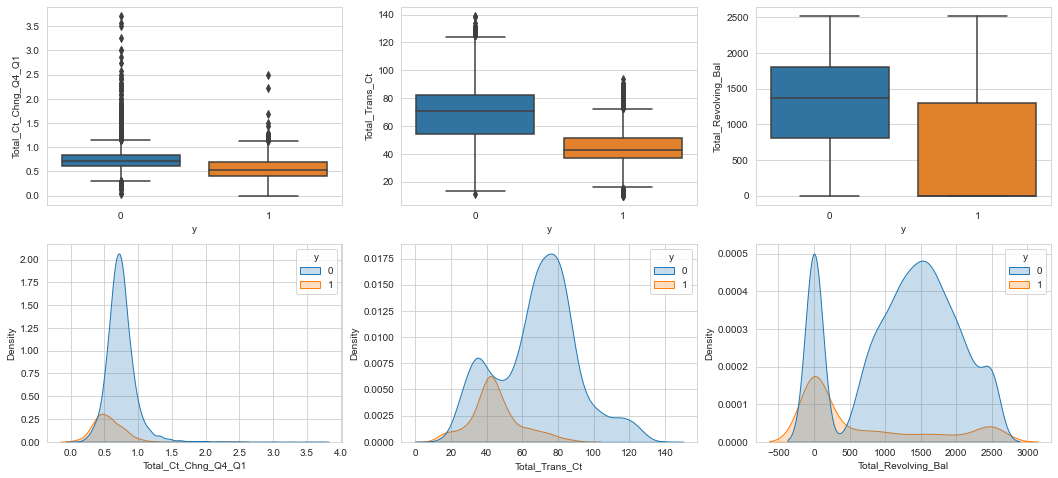

In [25]:
#plot most highly correlated features against response y

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

sns.boxplot(x='y',y='Total_Ct_Chng_Q4_Q1', data=df, ax=axs[0,0])
sns.boxplot(x='y',y='Total_Trans_Ct', data=df, ax=axs[0,1])
sns.boxplot(x='y',y='Total_Revolving_Bal', data=df, ax=axs[0,2])

sns.kdeplot('Total_Ct_Chng_Q4_Q1',data=df, hue='y', shade=True, ax=axs[1,0])
sns.kdeplot(x='Total_Trans_Ct',data=df, hue='y', shade=True, ax=axs[1,1])
sns.kdeplot(x='Total_Revolving_Bal',data=df, hue='y', shade=True, ax=axs[1,2])


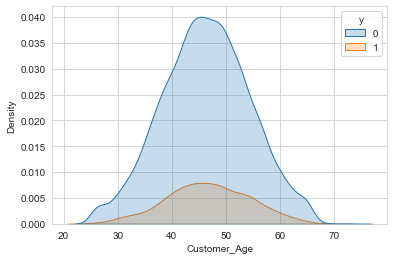

In [30]:
#plot age - not highly correlated with y
sns.kdeplot(x='Customer_Age',data=df, hue='y',shade=True)

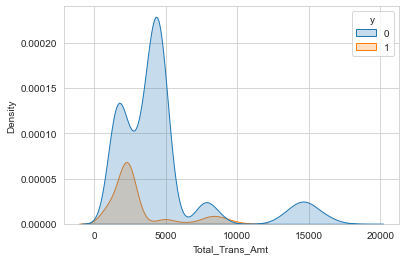

In [53]:
sns.kdeplot(x='Total_Trans_Amt',data=df, hue='y', shade=True)

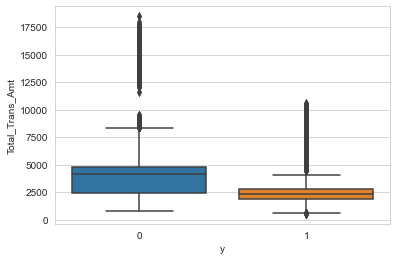

In [54]:
sns.boxplot(x='y',y='Total_Trans_Amt', data=df)

In [57]:
#average annual transaction amount for churners and non-churners
df.groupby('y').agg({'Total_Trans_Amt':np.average, 'Months_on_book':np.average})

,Total_Trans_Amt,Months_on_book
y,,
0,4654.655882,35.880588
1,3095.025814,36.178242


In [67]:
#Lifetime value of customer
p = 0.03 #profit margin, bank makes about 3% per transaction
ac = 3095 #total annual transaction amount for churner
an = 4654
t = 3 #retention time period in years 

# ltv = total annual transaction amount * margin per transaction * retention time period
churner_ltv = ac*p*t
nonchurner_ltv = an*p*t

print('churner ltv:',churner_ltv,'\n','non churner ltv:',nonchurner_ltv)

churner ltv: 278.54999999999995 
 non churner ltv: 418.86


## Data preprocessing

### Missing values

We confirmed above with df.info that there are no missing values in this dataset.
The below code is a template for imputing missing values.  For categorical features we choose 'most frequent' imputation and for numerical features we choose 'median'.  Variations of these techniques should be explored.

In [ ]:
#impute missing values - categorical columns
from sklearn.impute import SimpleImputer

#get categorical feautes and convert all values to string
categorical_features = df.select_dtypes(include=['object']).columns
cat = SimpleImputer(strategy='most_frequent',copy=False)
cat1 = cat.fit(df[categorical_features].astype(str))
df[categorical_features] = cat1.transform(df[categorical_features])

In [ ]:
#impute numeric columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
num = SimpleImputer(strategy='median',copy=False)
num1 = num.fit(df[numeric_features])
df[numeric_features] = num1.transform(df[numeric_features])

### Categorical Features

In [89]:
#get dummies on all categorical variables to create new numerical columns, then drop original columns
categorical_features = df.select_dtypes(include=['object']).columns
X = pd.get_dummies(df[categorical_features], prefix_sep='_')
X = pd.merge(df,X,how='outer',left_index=True,right_index=True)
X = X.drop(categorical_features, axis=1)
X.head()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


### Feature Engineering

In [45]:
#can use feature tools to generate features from your data. Better to evaluate model first and determine if this could help
import featuretools as ft


### Normalization / Scaling

In [90]:
#choose between standard, minmax, and robust scaler depending on application.  
# robust scaler preserves relationship with out skewing data so is a good choice when outliers are present
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
index = X.columns

transformer = scaler.fit_transform(X)
X = pd.DataFrame(transformer, columns = index)
X.head()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.0,-0.090909,0.5,0.333333,0.5,-1.0,1.0,0.956476,-0.350175,0.988927,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.272727,1.5,0.888889,1.0,-1.0,0.0,0.435477,-0.289123,0.459078,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.454545,0.5,0.000000,0.0,-1.0,-2.0,-0.132863,-0.895439,-0.006562,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.545455,1.0,-0.222222,-0.5,2.0,-1.0,-0.145198,0.870877,-0.313785,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.545455,0.5,-1.666667,0.5,-1.0,-2.0,0.019618,-0.895439,0.145527,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test Train Split

In [46]:
from sklearn.model_selection import train_test_split

X = X.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)
x_train.shape

(7595, 37)

### Over/Under Sampling 

In [47]:
#Notice the imbalance in classes: only 15% of samples are positive
y.value_counts()

0    8500
1    1627
dtype: int64

In [48]:
#oversample minor class to balance training set
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_train, y_train = sm.fit_sample(x_train, y_train)
x_train.shape

(12720, 37)

## Model Selection and Evaluation

In [74]:
#function to evaluate each model
def eval_model(model):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)
    auc_prob_val = roc_auc_score(y_test, probs[:,1])
    accuracy = accuracy_score(y_test, preds)
    print('AUC Score:', auc_prob_val,'\n','Accuracy:', accuracy)
    print('\n','Confusion Matrix','\n',confusion_matrix(y_test, preds))
    print('\n','Classification Report', '\n', classification_report(y_test, preds, digits=3))

### Logistic Regression

In [80]:
reg = LogisticRegression()
#define hyperparameters
solvers = ['newton-cg','lbfgs','liblinear']
penalty = ['l1','l2']
c = [100,10,1,.1,.01]
#define grid search
grid = dict(solver=solvers,penalty=penalty,C=c)
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=reg,param_grid=grid,n_jobs=-1,cv=cv,scoring='f1',error_score=0)
fit = grid_search.fit(x_train,y_train)

eval_model(fit)

AUC Score: 0.921795727636849 
 Accuracy: 0.8550552922590837

 Confusion Matrix 
 [[1842  298]
 [  69  323]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.964     0.861     0.909      2140
           1      0.520     0.824     0.638       392

    accuracy                          0.855      2532
   macro avg      0.742     0.842     0.774      2532
weighted avg      0.895     0.855     0.867      2532



### Random Forest

In [82]:
rf = RandomForestClassifier()

#define hyperparameters
n_estimators = [10,100,1000]
max_features = ['sqrt','log2']
#define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf,param_grid=grid,n_jobs=-1,cv=cv,scoring='f1',error_score=0)
fit = grid_search.fit(x_train,y_train)

eval_model(fit)

AUC Score: 0.9878361625023842 
 Accuracy: 0.9624802527646129

 Confusion Matrix 
 [[2092   48]
 [  47  345]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.978     0.978     0.978      2140
           1      0.878     0.880     0.879       392

    accuracy                          0.962      2532
   macro avg      0.928     0.929     0.928      2532
weighted avg      0.963     0.962     0.962      2532



In [83]:
print("Best: %f using %s" % (fit.best_score_, fit.best_params_))

Best: 0.979185 using {'max_features': 'sqrt', 'n_estimators': 1000}


### XG Boost

In [84]:
#run xgboost model
xgb = XGBClassifier()

#define hyperparameters
eta = [.1,.4,.7,1]
min_child_weight = [3,6,10]
max_depth = [.1,1,5,10]
#define grid search
grid = dict(eta=eta,min_child_weight=min_child_weight,max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=xgb,param_grid=grid,n_jobs=-1,cv=cv,scoring='f1',error_score=0)
fit = grid_search.fit(x_train,y_train)
print("Best: %f using %s" % (fit.best_score_, fit.best_params_))
eval_model(fit)

Best: 0.982374 using {'eta': 0.4, 'max_depth': 5, 'min_child_weight': 3}
AUC Score: 0.9938048350181193 
 Accuracy: 0.9735387045813586

 Confusion Matrix 
 [[2106   34]
 [  33  359]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.985     0.984     0.984      2140
           1      0.913     0.916     0.915       392

    accuracy                          0.974      2532
   macro avg      0.949     0.950     0.949      2532
weighted avg      0.974     0.974     0.974      2532



### XG Boost with Random Undersampling, Tomek Link Elimination, and model Bagging
Proven effective for highly noisy, class imbalanced data. Let's see how it performs on this dataset with 15% positive class (imbalanced, but not extremely so)

AUC Score0 : 0.9928029747948417 Accuracy:  0.956071076011846
AUC Score1 : 0.9930539273153576 Accuracy:  0.9536031589338598
AUC Score2 : 0.9915445486518172 Accuracy:  0.9570582428430404
AUC Score3 : 0.9927571805392732 Accuracy:  0.9619940769990128
AUC Score4 : 0.9904876172332943 Accuracy:  0.9545903257650543

 Feature importance
Total_Trans_Ct              25.066489
Total_Revolving_Bal         12.088030
Total_Relationship_Count     7.398918
Total_Trans_Amt              5.645457
Total_Ct_Chng_Q4_Q1          4.726806
Months_Inactive_12_mon       3.615556
Total_Amt_Chng_Q4_Q1         2.831294
Contacts_Count_12_mon        2.776851
Customer_Age                 2.439363
Name: cum_imp, dtype: float64

 Confusion Matrix 
 [[1637   69]
 [   8  312]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.995     0.960     0.977      1706
           1      0.819     0.975     0.890       320

    accuracy                          0.962      2026
   mac

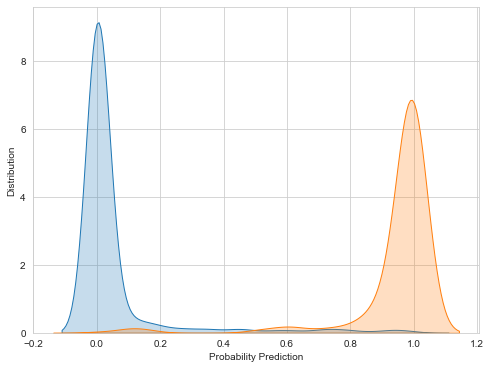

In [91]:
def xgbag(X, y, n):
    
    #test train split
    X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, y, test_size = 0.20,random_state = 12)
    
    #drop target column from test set
    X_Val = X_Val.drop('y',axis=1)

    #random sampling with replacement only on majority class
    X_Train_0 = X_Train[X_Train['y'] == 0]
    X_Train_1 = X_Train[X_Train['y'] == 1]
    
    #create dataframe for results
    yt = Y_Val.to_numpy()
    global bg
    bg = pd.DataFrame(data=yt, index=None, columns=['y'])
    global bg_test
    bg_test = pd.DataFrame(data=[], index=None, columns=[])

    #create dataframe for feature importances
    global importance
    importance = pd.DataFrame(data=None, index=X_Val.columns)

    #loop to execute steps 1-3
    for i in range(n):
        #create random samples from majority class
        X_Train_0_sample = X_Train_0.sample(2000)
        
        #combine random sample with minority class
        X_Train_sample = pd.concat([X_Train_0_sample, X_Train_1])
        
        #tomek links undersampling to remove links (assumes target variable is in first column)
        tl = TomekLinks(sampling_strategy='majority')
        X_Train_res1, Y_Train_res1 = tl.fit_resample(X_Train_sample.iloc[:,1:], X_Train_sample.iloc[:,0])
        
        #run xgboost model
        est1 = XGBClassifier(eta=0.4, min_child_weight=3, max_depth=5)
        eval_set = [(X_Val,Y_Val)]
        est1.fit(X_Train_res1, Y_Train_res1) #early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

        val_preds = est1.predict_proba(X_Val)
        val_class_preds = est1.predict(X_Val)
        auc_prob_val = roc_auc_score(Y_Val, val_preds[:,1])
        accuracy = accuracy_score(Y_Val, val_class_preds)
        print('AUC Score%s :'%i, auc_prob_val, 'Accuracy: ', accuracy)
        
        #test_preds = est1.predict_proba(X_test)

        #append predictions to results dataframe
        bg['pred%s' %i] = val_preds[:,1]
        #bg_test['pred%s' %i] = test_preds[:,1]
        
        #get most important features
        f = 'gain'
        g = est1.get_booster().get_score(importance_type= f)
        j = pd.Series(g).to_frame()        
        importance = importance.merge(j,how='outer',left_index=True, right_index=True)

    # 4 - bagging classifiers i.e. take average of predictions for each row in test data
    col = bg.loc[: , "pred0":"pred%s"%i]
    bg['cum_prob'] = col.mean(axis=1)
    bg['cum_pred'] = np.where(bg['cum_prob'] > 0.5, 1, 0)
    
    bg_test['cum_prob'] = col.mean(axis=1)
    
    print('\n','Feature importance')
    col2 = importance.iloc[: , 0:n]
    importance['cum_imp'] = col2.mean(axis=1)
    importance = importance.sort_values(by=['cum_imp'], ascending=False)
    print(importance['cum_imp'][0:9])

    #print results
    print('\n','Confusion Matrix','\n',confusion_matrix(bg['y'], bg['cum_pred']))
    print('\n','Classification Report', '\n', classification_report(bg['y'], bg['cum_pred'], digits=3))
    auc_prob = roc_auc_score(bg['y'], bg['cum_prob'])
    print('\n','ROC AUC Score : ',auc_prob)
    
    #plot probabilities 
    pr_pos = bg[bg['y'] == 1]
    pr_neg = bg[bg['y'] == 0]

    plt.figure(figsize=(8,6))
    #plt.hist([pr_neg['cum_prob'], pr_pos['cum_prob']], bins=20, alpha=0.5, density=True)
    sns.set_style()
    sns.kdeplot(pr_neg['cum_prob'], shade=True, label = 'Negative Class Predictions')
    sns.kdeplot(pr_pos['cum_prob'], shade=True, label = 'Positive Class Predictions')
    plt.ylabel('Distribution', fontsize=10)
    plt.xlabel('Probability Prediction', fontsize=10)

    
       
xgbag(X,y,5)

In [94]:
d = {'FP %': [11.7,1.9,1.3,3.4], 'FN %': [2.7,1.9,1.3,0.4]}
df = pd.DataFrame(data=d, index=['Logistic Regression', 'Random Forest', 'XGBoost', 'XGBoost+'])
df

,FP %,FN %
Logistic Regression,11.7,2.7
Random Forest,1.9,1.9
XGBoost,1.3,1.3
XGBoost+,3.4,0.4


## Summary

Now, we can calculate the expected value per prediction (EvP) in comparing our more advanced models to our baseline logistic regression model.

EvP = FP cost * change in FP % + FN cost * change in FN %

For our xgboost model, EvP = 100 * .104 + 278.5 * .014 = $14.6 savings per customer

For the xgboost+ model, EvP = 100 * .083 + 278.5 * .023 = $15.2 savings per customer

We see that our XGBoost model with random undersampling, tomek link elimination, and model bagging ultimately saves the bank more money by identifying a greater percentage of true positives (i.e. churner customers) even while resulting in more false positives that cost the bank money.

This is an expected result since the random undersampling and tomek link elimination are intended to improve our ability to correctly predict the minor class. This is a useful approach in any class imbalanced problem where the cost of false negatives outweighs the cost of false positives.